## Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
batch_size = 64
IMG_LEN = 224

## Load data

In [ ]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [ ]:
size = (IMG_LEN, IMG_LEN)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

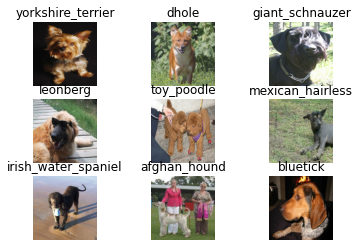

In [ ]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


## Data augmentation

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

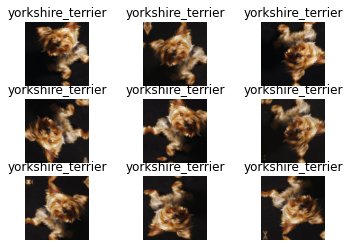

In [ ]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

## Prepare input

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

## Base Model

In [ ]:
from tensorflow.keras.applications import ResNet50

inputs = Input(shape=(IMG_LEN, IMG_LEN, 3))
x = img_augmentation(inputs)

base_model = ResNet50(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

# 用比較大的learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

# model.summary()

history = model.fit(ds_train, epochs=25, validation_data=ds_test, verbose=2)

Epoch 1/25
187/187 - 34s - loss: 5.8271 - accuracy: 0.1979 - val_loss: 2.4934 - val_accuracy: 0.4347
Epoch 2/25
187/187 - 31s - loss: 2.6648 - accuracy: 0.3697 - val_loss: 1.8135 - val_accuracy: 0.5162
Epoch 3/25
187/187 - 31s - loss: 2.2510 - accuracy: 0.4181 - val_loss: 1.8097 - val_accuracy: 0.5282
Epoch 4/25
187/187 - 31s - loss: 2.1411 - accuracy: 0.4478 - val_loss: 1.8153 - val_accuracy: 0.5250
Epoch 5/25
187/187 - 31s - loss: 2.0809 - accuracy: 0.4549 - val_loss: 1.8793 - val_accuracy: 0.5195
Epoch 6/25
187/187 - 31s - loss: 2.0661 - accuracy: 0.4628 - val_loss: 1.9258 - val_accuracy: 0.5147
Epoch 7/25
187/187 - 31s - loss: 2.0256 - accuracy: 0.4705 - val_loss: 1.8997 - val_accuracy: 0.5273
Epoch 8/25
187/187 - 31s - loss: 2.0186 - accuracy: 0.4728 - val_loss: 1.9464 - val_accuracy: 0.5241
Epoch 9/25
187/187 - 31s - loss: 2.0091 - accuracy: 0.4733 - val_loss: 1.9815 - val_accuracy: 0.5222
Epoch 10/25
187/187 - 31s - loss: 1.9723 - accuracy: 0.4823 - val_loss: 2.0435 - val_accura

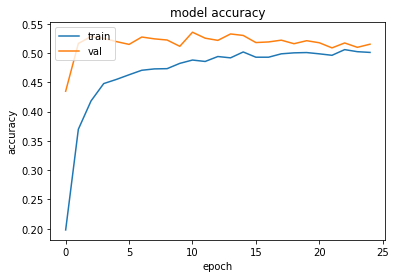

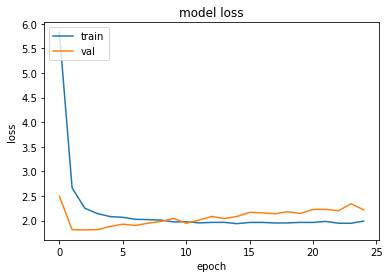

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Re-train partial model

In [ ]:
def unfreeze_model(model):
    # Unfreeze the top 25 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-25:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # 用比較小的learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

history = model.fit(ds_train, epochs=30, validation_data=ds_test, verbose=2)

Epoch 1/30
187/187 - 75s - loss: 1.9692 - accuracy: 0.5117 - val_loss: 1.8817 - val_accuracy: 0.5711
Epoch 2/30
187/187 - 69s - loss: 1.5575 - accuracy: 0.5931 - val_loss: 1.8765 - val_accuracy: 0.5747
Epoch 3/30
187/187 - 69s - loss: 1.3485 - accuracy: 0.6291 - val_loss: 1.8071 - val_accuracy: 0.5879
Epoch 4/30
187/187 - 69s - loss: 1.2084 - accuracy: 0.6562 - val_loss: 1.7458 - val_accuracy: 0.5965
Epoch 5/30
187/187 - 69s - loss: 1.1124 - accuracy: 0.6835 - val_loss: 1.7319 - val_accuracy: 0.5957
Epoch 6/30
187/187 - 69s - loss: 1.0367 - accuracy: 0.6967 - val_loss: 1.6907 - val_accuracy: 0.6019
Epoch 7/30
187/187 - 69s - loss: 0.9394 - accuracy: 0.7190 - val_loss: 1.6476 - val_accuracy: 0.6098
Epoch 8/30
187/187 - 69s - loss: 0.8729 - accuracy: 0.7387 - val_loss: 1.6445 - val_accuracy: 0.6129
Epoch 9/30
187/187 - 69s - loss: 0.8292 - accuracy: 0.7482 - val_loss: 1.6302 - val_accuracy: 0.6139
Epoch 10/30
187/187 - 69s - loss: 0.7719 - accuracy: 0.7688 - val_loss: 1.6056 - val_accura

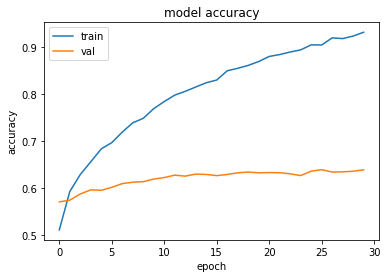

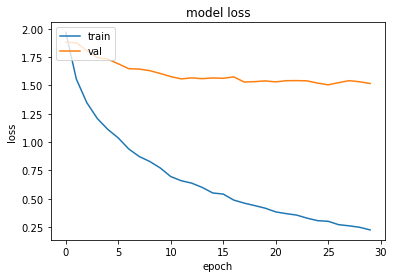

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()